In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np

In [18]:
x = torch.unsqueeze(torch.linspace(-1,1,100),dim=1)
y = x.pow(3)+0.1*torch.randn(x.size())

In [27]:
mini_batch_size=6
n_states = 20  # memory记录数量=20
batch_start = np.arange(0, n_states, mini_batch_size)  # 每个batch开始的位置[0,5,10,15]
indices = np.arange(n_states, dtype=np.int64)  # 记录编号[0,1,2....19]
np.random.shuffle(indices)  # 打乱编号顺序[3,1,9,11....18]
mini_batches = [indices[i:i + mini_batch_size] for i in batch_start] 
print(mini_batches)

[array([ 0, 13,  6, 14, 18,  9]), array([ 7, 15,  5,  4,  8,  3]), array([17, 12,  2, 11, 10, 16]), array([ 1, 19])]


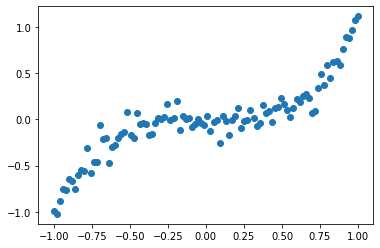

In [5]:
x , y =(Variable(x),Variable(y))

plt.scatter(x.data,y.data)
# 或者采用如下的方式也可以输出x,y
# plt.scatter(x.data.numpy(),y.data.numpy())
plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(self).__init__()
        pass
    def forward(self):
        pass

In [6]:
class Net(nn.Module):
    def __init__(self,n_input,n_hidden,n_output):
        super(Net,self).__init__()
        self.hidden1 = nn.Linear(n_input,n_hidden)
        self.hidden2 = nn.Linear(n_hidden,n_hidden)
        self.predict = nn.Linear(n_hidden,n_output)
    def forward(self,input):
        out = self.hidden1(input)
        out = F.relu(out)
        out = self.hidden2(out)
        out = F.sigmoid(out)
        out =self.predict(out)

        return out

In [7]:
net = Net(1,20,1)
print(net)

Net(
  (hidden1): Linear(in_features=1, out_features=20, bias=True)
  (hidden2): Linear(in_features=20, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


In [ ]:
optimizer = torch.optim.SGD(net.parameters(),lr = 0.1)
loss_func = torch.nn.MSELoss()
# plt.ion()
# plt.show()

for t in range(5000):
    prediction = net(x)
    loss = loss_func(prediction,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#     if t%5 ==0:
#         plt.cla()
#         plt.scatter(x.data.numpy(), y.data.numpy())
#         plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
#         plt.text(0.5, 0, 'Loss = %.4f' % loss.data, fontdict={'size': 20, 'color': 'red'})
#         plt.pause(0.05)

# plt.ioff()
# plt.show()

In [11]:
class PPOmemory:
    def __init__(self, mini_batch_size):
        self.states = []  # 状态
        self.actions = []  # 实际采取的动作
        self.probs = []  # 动作概率
        self.vals = []  # critic输出的状态值
        self.rewards = []  # 奖励
        self.dones = []  # 结束标志

        self.mini_batch_size = mini_batch_size  # minibatch的大小

    def sample(self):
        n_states = len(self.states)  # memory记录数量=20
        batch_start = np.arange(0, n_states, self.mini_batch_size)  # 每个batch开始的位置[0,5,10,15]
        indices = np.arange(n_states, dtype=np.int64)  # 记录编号[0,1,2....19]
        np.random.shuffle(indices)  # 打乱编号顺序[3,1,9,11....18]
        mini_batches = [indices[i:i + self.mini_batch_size] for i in batch_start]  # 生成4个minibatch，每个minibatch记录乱序且不重复

        return np.array(self.states), np.array(self.actions), np.array(self.probs), \
               np.array(self.vals), np.array(self.rewards), np.array(self.dones), mini_batches

    # 每一步都存储trace到memory
    def push(self, state, action, prob, val, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(prob)
        self.vals.append(val)
        self.rewards.append(reward)
        self.dones.append(done)

    # 固定步长更新完网络后清空memory
    def clear(self):
        self.states = []
        self.actions = []
        self.probs = []
        self.vals = []
        self.rewards = []
        self.dones = []


In [13]:
# actor:policy network
class Actor(nn.Module):
    def __init__(self, n_states, n_actions, cfg):
        super(Actor, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(n_states, cfg.hidden_dim),
            nn.Tanh(),
            nn.Linear(cfg.hidden_dim, cfg.hidden_dim),
            nn.Tanh(),
            nn.Linear(cfg.hidden_dim, n_actions),
            nn.Softmax(dim=-1))

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist


In [14]:
# critic:value network
class Critic(nn.Module):
    def __init__(self, n_states, hidden_dim):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Linear(n_states, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1))

    def forward(self, state):
        value = self.critic(state)
        return value


In [51]:
def __gaussianSampleData(self, mu, sigma):
    # sample N examples
    sample_matrix = np.zeros((self.N, self.d))
    for j in range(self.d):
        sample_matrix[:,j] = np.random.normal(loc=mu[j], scale=sigma[j], size=(self.N,))
    if self.v_min is not None and self.v_max is not None:
        sample_matrix[:,0:self.d:self.dof] = np.clip(sample_matrix[:,0:self.d:self.dof],  self.v_min[0], self.v_max[0])
        sample_matrix[:,1:self.d:self.dof] = np.clip(sample_matrix[:,1:self.d:self.dof],  self.v_min[1], self.v_max[1])
        sample_matrix[:,2:self.d:self.dof] = np.clip(sample_matrix[:,2:self.d:self.dof],  self.v_min[-1], self.v_max[-1])
    return sample_matrix

随机生成一个6维的数组 前四个数范围：[0,0]至 [8,8]的正方形内  后两个 0到7 

前四个高斯分布 方差为2

def env_reset():
    states = np.zeros(6)
    mu= np.array([2.57696126, 2.34334736, 6.38525582, 3.0674252])
    for i in range(4):
        states[i] = np.random.normal(loc=mu[j], scale=2)
    states[4]=np.random.uniform(0,7)
    states[5]=np.random.uniform(0,7)
    states[:4]=  np.clip(states[:4],  0, 8)
        


array([16.38525582, 13.0674252 ])

In [84]:

def env_reset():
    states = np.zeros(6)
    mu= np.array([2.57696126, 2.34334736, 6.38525582, 3.0674252])
    for i in range(4):
        states[i] = np.random.normal(loc=mu[i], scale=1)
    states[4]=np.random.uniform(0,7)
    states[5]=np.random.uniform(0,7)
    states[:4]=  np.clip(states[:4],  0, 8)
    return states
env_reset()

array([1.16813553, 4.53502492, 5.24310259, 3.15875568, 5.84753346,
       0.72930052])

In [66]:
mu= np.array([2.57696126, 2.34334736, 6.38525582, 3.0674252])
mu[:3]

array([2.57696126, 2.34334736, 6.38525582])

In [60]:

limit= np.array([[5,6],[3,4]])
# reward, done, _ = get_reward(state,action)

# state: start, end , obstcle   长和宽为一的正方形 只要确定左下角的x和y
# 轨迹平均起点[2.57696126, 2.34334736] 平均终点[6.38525582, 3.0674252 ])  平均长度为  3.876518563635841

# 轨迹限制在加减10以内: [-7,-7]至  [15,15]的正方形内

# 起点[-7.42303874, -7.65665264] 至[12.57696126, 12.34334736]
# 终点：[-3.61474418, -6.9325748 ]至[16.38525582, 13.0674252 ]



# 给定mean的起点终点 fid最小为48 此时mean轨迹完全一样 只是方差不同
# state = [x_start,y_start,x_end,y_end,x_obs,y_obs]  维度为6

# 先尝试一个via point，此时action维度为3

def env_reset():
    


def get_reward(state, action):
       
    old_promp=promp
    action = action.reshape([-1,3])
    t_cond = np.zeros(2+action.shape[0])
    t_cond[0]=0
    t_cond[-1] = 1 
    for i in range(action.shape[0]):
        t_cond[i+1]=action[i,2]

    q_cond =np.zeros([2+action.shape[0],2])
    q_cond[0]= np.array([state[0],state[1]])
    q_cond[-1]=np.array([state[2],state[3]])
    for i in range(action.shape[0]):
        q_cond[i+1]=action[i,:2]
        
    mu_w_cond_rec, Sigma_w_cond_rec=old_promp.get_basis_weight_parameters()

    for i in range(t_cond.shape[0]):
        mu_w_cond_rec, Sigma_w_cond_rec = old_promp.get_conditioned_weights(t_cond[i], q_cond[i], mean_w=mu_w_cond_rec, var_w=Sigma_w_cond_rec)

    cond_traj = np.zeros([2,100])
    sigma_con_array =np.zeros([2,2,100]) 
    for i in range(len(domain)):
        mu_marg_q_con, Sigma_marg_q_con = promp.get_marginal(domain[i], mu_w_cond_rec, Sigma_w_cond_rec)
        sigma_con_array[:,:,i] = Sigma_marg_q_con
        cond_traj[:,i] = mu_marg_q_con

    limit = np.array([[state[4],state[4]+1],[state[5],state[5]+1]])   
    obs_dis= traj_rect_dist(cond_traj.T,  limit)

    # mu_1= mean_margs.T.reshape(-1)
    mu_2= cond_traj.T.reshape(-1)
    # sigma_1 = np.zeros([200,200])
    sigma_2 = np.zeros([200,200])
    for i in range(100):
        # sigma_1[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_s[:,:,i]
        sigma_2[i*2:(i+1)*2,i*2:(i+1)*2] = sigma_con_array[:,:,i]
    fid_cost= calculate_frechet_distance(mu_1,sigma_1,mu_2,sigma_2) *0.01

    alif =0.5
#     reward =  alif* fid_cost  -obs_dis*(1-alif)
    reward =  obs_dis*(1-alif) - alif* fid_cost 
    return reward

In [ ]:
def train(cfg, agent):
    print('开始训练！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    figure_file = 'plots/cartpole.png'
    rewards = []
    steps = 0
    for i_ep in range(cfg.train_eps):
        state = env_reset()
        ep_reward = 0
            
        action, prob, val = agent.choose_action(state)
        reward = get_reward(state,action)

        ep_reward += reward
        agent.memory.push(state, action, prob, val, reward, done)
        if steps % cfg.batch_size == 0:
            agent.learn()

        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep + 1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")

In [90]:
def choose_action(self, state):
    state = torch.tensor(state, dtype=torch.float).to(self.device)  # 数组变成张量
    dist = self.actor(state)  # action分布
    value = self.critic(state)  # state value值
    action = dist.sample()  # 随机选择action
    prob = torch.squeeze(dist.log_prob(action)).item()  # action对数概率

    action = torch.squeeze(action).item()
    value = torch.squeeze(value).item()
    return action, prob, value

In [ ]:
   def sample_action(self, state):
        state = np.array([state]) # 先转成数组再转tensor更高效
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        probs = self.actor(state)
        dist = Categorical(probs)
        value = self.critic(state)
        action = dist.sample()
        probs = torch.squeeze(dist.log_prob(action)).item()
        if self.continuous:
            action = torch.tanh(action)
        else:
            action = torch.squeeze(action).item()

In [97]:
import gym
# env = gym.make('CartPole-v1')
env = gym.make('Pendulum-v1')

n_states = env.observation_space.shape[0]
print(n_states)
n_actions = env.action_space.shape[0]
print(n_actions)

3
1


In [93]:
action = torch.tensor([1,2,3,4])
# action = torch.tanh(action)
action = torch.squeeze(action).item()

print(action)


ValueError: only one element tensors can be converted to Python scalars

In [106]:
# probs = torch.FloatTensor([[0.05,0.1,0.85],[0.05,0.05,0.9]])
probs = torch.FloatTensor([0.05])
dist = Categorical(probs)
print(dist)
# Categorical(probs: torch.Size([2, 3]))
 
index = dist.sample()
print(index.numpy())
# [2 2]

Categorical(probs: tensor([1.]))
0


In [147]:
class Actor(nn.Module):
    def __init__(self, n_states, n_actions,  chkpt_dir='/home/zhiyuan/notebook_script/cem_promp/ppo_model'):
        super(Actor, self).__init__()
#         self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.stds = nn.Parameter(torch.zeros(n_actions))
        self.actor = nn.Sequential(
            nn.Linear(n_states, 5),
            nn.Tanh(),
            nn.Linear(5,5),
            nn.Tanh(),
            nn.Linear(5, n_actions))
            # nn.Softmax(dim=-1))

    def forward(self, state):
        dist = torch.distributions.Normal(loc=self.actor(state), scale=self.stds.exp())
        
        return dist



In [152]:
# agent.actor(state) 

actor =Actor(6,3)
state= torch.Tensor([0,1,2,3,4,5])
# actor(state)
dist=actor(state)
action = dist.sample()

In [153]:
print(dist)

Normal(loc: torch.Size([3]), scale: torch.Size([3]))


In [154]:
dist.log_prob(action)

tensor([-2.1093, -2.2647, -1.5504], grad_fn=<SubBackward0>)

In [133]:
 dist.log_prob(action)

[-1.9641942 -1.035494   0.4620923]


In [131]:
state=[]
state.append(ac0)
state.append(ac0)
state
len(state)

2

In [111]:
class Policy(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, num_outputs):
        super(Policy, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_dim, n_hidden_1),
            nn.ReLU(True),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.ReLU(True),
            nn.Linear(n_hidden_2, num_outputs)
        )
        
    

class Normal(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.stds = nn.Parameter(torch.zeros(num_outputs))
    def forward(self, x):
        dist = torch.distributions.Normal(loc=x, scale=self.stds.exp())
        action = dist.sample()
        return action

policy = Policy(4,20,20,5)
normal = Normal(5)
observation = torch.Tensor(4)
action = normal.forward(policy.layer( observation))

print("action: ",action)
policy.layer( observation)


action:  tensor([-1.3480e+22,  9.9787e+21,  9.4780e+21, -1.9552e+22,  7.5754e+21])


tensor([-1.3480e+22,  9.9787e+21,  9.4780e+21, -1.9552e+22,  7.5754e+21],
       grad_fn=<AddBackward0>)

In [114]:
stds = nn.Parameter(torch.zeros(5))
stds.exp()

tensor([1., 1., 1., 1., 1.], grad_fn=<ExpBackward0>)

In [ ]:
class Actor(nn.Module):
    def __init__(self, n_states, n_actions, cfg, chkpt_dir='/home/zhiyuan/notebook_script/cem_promp/ppo_model'):
        super(Actor, self).__init__()
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.stds = nn.Parameter(torch.ones(n_actions))*0.1
        self.actor = nn.Sequential(
            nn.Linear(n_states, cfg.hidden_dim),
            nn.Tanh(),
            nn.Linear(cfg.hidden_dim, cfg.hidden_dim),
            nn.Tanh(),
            nn.Linear(cfg.hidden_dim, n_actions))
            # nn.Softmax(dim=-1))

    def forward(self, state):
        dist = torch.distributions.Normal(loc=self.actor(state), scale=self.stds)
        # action = dist.sample()
        return dist

In [142]:
import torch
a=[]
b=torch.randn(3)
a.append(b.numpy())
a.append(b.numpy())



In [143]:
a

[array([-0.50802594, -2.4233036 ,  0.63315946], dtype=float32),
 array([-0.50802594, -2.4233036 ,  0.63315946], dtype=float32)]

In [144]:

d=np.array(a)


In [146]:
d.shape

(2, 3)

In [ ]:
ndarray = np.array(list)  # list 转 numpy数组
list = ndarray.tolist()  # numpy 转 list
tensor=torch.Tensor(list)  # list 转 torch.Tensor
list = tensor.numpy().tolist()  # torch.Tensor 转 list  先转numpy，后转list
ndarray = tensor.cpu().numpy()  # torch.Tensor 转 numpy  *gpu上的tensor不能直接转为numpy
tensor = torch.from_numpy(ndarray)  # numpy 转 torch.Tensor


In [162]:
prob=torch.Tensor([ 0.8182,  1.2037, -0.3921])

In [163]:
probs=[]
probs.append(prob)

In [164]:
probs

[tensor([ 0.8182,  1.2037, -0.3921])]

In [166]:
a =probs[0]
a

tensor([ 0.8182,  1.2037, -0.3921])